In [2]:
import tensorflow as tf
import os
import cv2
import imghdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from itertools import chain
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [3]:
train_data = []
test_data = []
non_chars = ["#","$","&","@","1","2","3","4","5","6","7","8","9","0"]
img_size = 32
num_images_per_folder_TR = 8000
num_images_per_folder_TS = 3000

# 1. Loading Data 

In [4]:
train_dir ='/kaggle/input/handwritten-characters/Train'
test_dir ='/kaggle/input/handwritten-characters/Validation'

* Resize all data to one size (32,32)
* Convert image from (R,G,B) to binary (1 or 0)

In [6]:
def to_binary(image):
    image = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),dsize=(32,32))
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    (thresh, image_binary) = cv2.threshold(image_gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    image_binary = cv2.threshold(image_gray, thresh, 255, cv2.THRESH_BINARY)[1]
    return image_binary

In [7]:
for files in os.listdir(train_dir):
    if files in non_chars:
        continue
    count = 0
    files_path = os.path.join(train_dir,files)
    images_list = os.listdir(files_path)
    # We mix the data in case the capital letters come first or vice versa
    selected_images = random.sample(images_list, min(num_images_per_folder_TR, len(images_list)))
    for image in selected_images:
        count += 1
        if count > num_images_per_folder_TR:
            break
        img_path = os.path.join(files_path,image)
        img = cv2.imread(img_path)
        image_binary = to_binary(img)
        train_data.append([image_binary,files])

In [8]:
for files in os.listdir(test_dir):
    if files in non_chars:
        continue
    count = 0
    files_path = os.path.join(test_dir,files)
    images_list = os.listdir(files_path)
    selected_images = random.sample(images_list, min(num_images_per_folder_TS, len(images_list)))
    for image in selected_images:
        count += 1
        if count > num_images_per_folder_TS:
            break
        img_path = os.path.join(files_path,image)
        img = cv2.imread(img_path)
        image_binary = to_binary(img)
        test_data.append([image_binary,files])

In [9]:
len(train_data) , len(test_data)

(177992, 6651)

(32, 32)


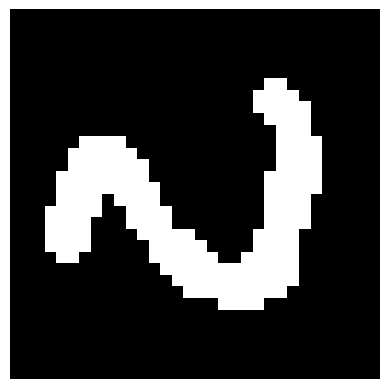

latter : N


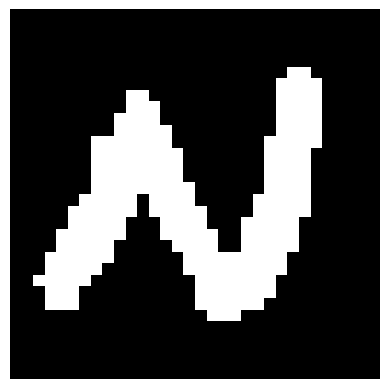

In [10]:
print(train_data[0][0].shape)
plt.imshow(train_data[0][0],cmap='gray')
plt.axis('off')
plt.show()
print("latter :",test_data[11][1])
plt.imshow(test_data[11][0],cmap='gray')
plt.axis('off')
plt.show()

In [11]:
#mix all data
random.shuffle(train_data)
random.shuffle(test_data)

# 2. Split data

In [12]:
train_X = []
train_Y = []
for features,label in train_data:
    train_X.append(features)
    train_Y.append(label)

In [13]:
test_X = []
test_Y = []
for features,label in test_data:
    test_X.append(features)
    test_Y.append(label)

Encode each character into vector as {‘a’:[1,0,0,0], ‘b’:[0,1,0,0] …….. ‘z’:[0,0,0,1]}.

In [14]:
LB = LabelBinarizer()
train_Y = LB.fit_transform(train_Y)
test_Y = LB.fit_transform(test_Y)

In [15]:
train_X = np.array(train_X)/255.0
train_X = train_X.reshape(-1,img_size,img_size,1)
test_X = np.array(test_X)/255.0
test_X = test_X.reshape(-1,img_size,img_size,1)

In [16]:
#from list to numpy array 
train_Y = np.array(train_Y)
test_Y = np.array(test_Y)

In [17]:
print(train_X.shape,train_Y.shape)
print(test_X.shape,test_Y.shape)

(177992, 32, 32, 1) (177992, 25)
(6651, 32, 32, 1) (6651, 25)


# 3. Creat model

In [18]:
model = Sequential()

In [19]:
model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(32,32,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(25, activation='softmax'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 128)         0

In [21]:
model.compile(loss='categorical_crossentropy', optimizer="adam",metrics=['accuracy'])

In [21]:
history = model.fit(train_X,train_Y, epochs=20, batch_size=32, validation_data = (test_X, test_Y),  verbose=1)

Epoch 1/20
5563/5563 [==============================] - 151s 27ms/step - loss: 0.4173 - accuracy: 0.8671 - val_loss: 0.2743 - val_accuracy: 0.9074
Epoch 2/20
5563/5563 [==============================] - 151s 27ms/step - loss: 0.2316 - accuracy: 0.9241 - val_loss: 0.2435 - val_accuracy: 0.9163
Epoch 3/20
5563/5563 [==============================] - 150s 27ms/step - loss: 0.2029 - accuracy: 0.9324 - val_loss: 0.2322 - val_accuracy: 0.9232
Epoch 4/20
5563/5563 [==============================] - 150s 27ms/step - loss: 0.1872 - accuracy: 0.9363 - val_loss: 0.2187 - val_accuracy: 0.9251
Epoch 5/20
5563/5563 [==============================] - 153s 27ms/step - loss: 0.1753 - accuracy: 0.9395 - val_loss: 0.2119 - val_accuracy: 0.9295
Epoch 6/20
5563/5563 [==============================] - 154s 28ms/step - loss: 0.1679 - accuracy: 0.9420 - val_loss: 0.2049 - val_accuracy: 0.9293
Epoch 7/20
5563/5563 [==============================] - 155s 28ms/step - loss: 0.1613 - accuracy: 0.9429 - val_loss: 0

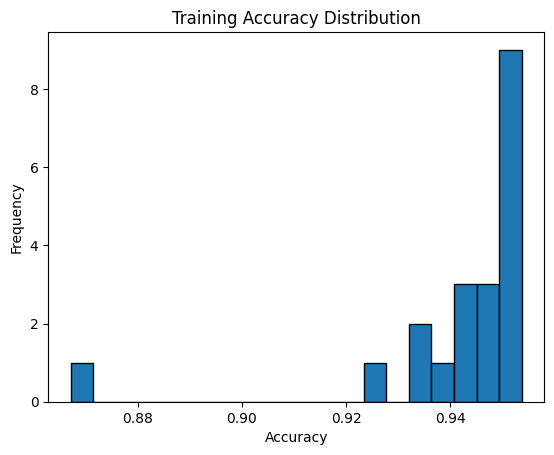

In [22]:
plt.hist(history.history['accuracy'], bins=20, edgecolor='black')
plt.title('Training Accuracy Distribution')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.show()

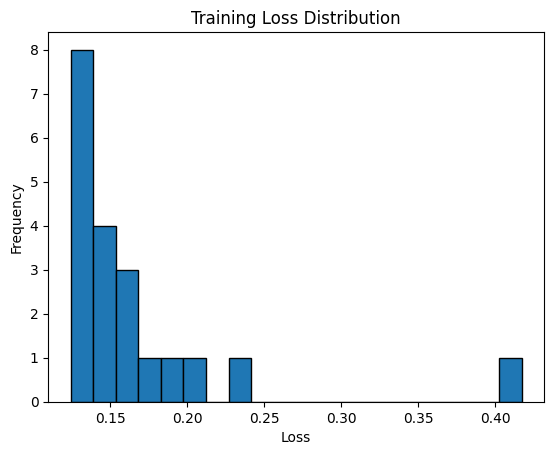

In [23]:
plt.hist(history.history['loss'], bins=20, edgecolor='black')
plt.title('Training Loss Distribution')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.show()

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from Levenshtein import distance

# Assuming you have already trained the model and have predictions stored in 'model'

# Evaluate the model
predictions = model.predict(test_X)

# Convert one-hot encoded labels to class labels
y_true = np.argmax(test_Y, axis=1)
y_pred = np.argmax(predictions, axis=1)

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Calculate Character Error Rate (CER) and Word Error Rate (WER)
cer = 0
wer = 0
for true_label, pred_label in zip(test_Y, predictions):
    true_label = LB.inverse_transform(np.array([true_label]))[0]
    pred_label = LB.inverse_transform(np.array([pred_label]))[0]
    cer += distance(true_label, pred_label) / max(len(true_label), 1)
    if true_label != pred_label:
        wer += 1
cer /= len(test_Y)
wer /= len(test_Y)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Character Error Rate (CER):", cer)
print("Word Error Rate (WER):", wer)


208/208 [==============================] - 2s 9ms/step
Accuracy: 0.9294842880769809
Precision: 0.9327665950397043
Recall: 0.9294842880769809
F1 Score: 0.9295580836106336
Character Error Rate (CER): 0.0705157119230191
Word Error Rate (WER): 0.0705157119230191


In [29]:
# Save the model to a file
model.save("/kaggle/working/model.h5")


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from Levenshtein import distance
from keras.models import load_model

# Load the saved model
model = load_model("/kaggle/input/model-cnn/model.h5")

# Assuming you have test data and labels loaded and preprocessed
# Assuming test_X and test_Y are loaded

# Evaluate the model
predictions = model.predict(test_X)

# Convert one-hot encoded labels to class labels
y_true = np.argmax(test_Y, axis=1)
y_pred = np.argmax(predictions, axis=1)

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Calculate Character Error Rate (CER) and Word Error Rate (WER)
cer = 0
wer = 0
for true_label, pred_label in zip(test_Y, predictions):
    true_label = LB.inverse_transform(np.array([true_label]))[0]
    pred_label = LB.inverse_transform(np.array([pred_label]))[0]
    cer += distance(true_label, pred_label) / max(len(true_label), 1)
    if true_label != pred_label:
        wer += 1
cer /= len(test_Y)
wer /= len(test_Y)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Character Error Rate (CER):", cer)
print("Word Error Rate (WER):", wer)


208/208 [==============================] - 2s 11ms/step
Accuracy: 0.9294842880769809
Precision: 0.9327665950397043
Recall: 0.9294842880769809
F1 Score: 0.9295580836106336
Character Error Rate (CER): 0.0705157119230191
Word Error Rate (WER): 0.0705157119230191


208/208 [==============================] - 2s 10ms/step


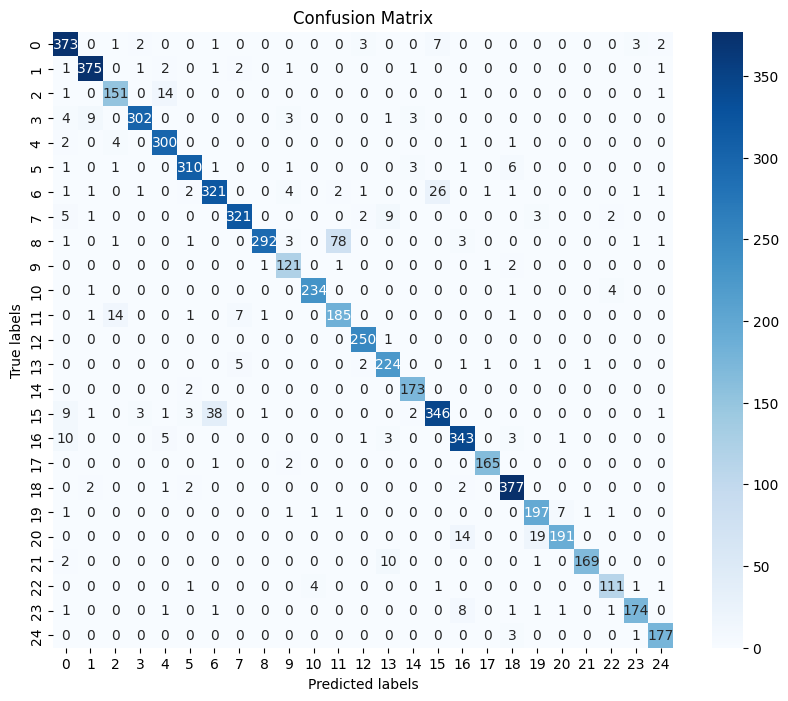

Accuracy: 0.9294842880769809
Precision: 0.9327665950397043
Recall: 0.9294842880769809
F1 Score: 0.9295580836106336
Character Error Rate (CER): 0.0705157119230191
Word Error Rate (WER): 0.0705157119230191


In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from Levenshtein import distance
from keras.models import load_model
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the saved model
model = load_model("/kaggle/input/model-cnn/model.h5")

# Assuming you have test data and labels loaded and preprocessed
# Assuming test_X and test_Y are loaded

# Evaluate the model
predictions = model.predict(test_X)

# Convert one-hot encoded labels to class labels
y_true = np.argmax(test_Y, axis=1)
y_pred = np.argmax(predictions, axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Calculate Character Error Rate (CER) and Word Error Rate (WER)
cer = 0
wer = 0
for true_label, pred_label in zip(test_Y, predictions):
    true_label = LB.inverse_transform(np.array([true_label]))[0]
    pred_label = LB.inverse_transform(np.array([pred_label]))[0]
    cer += distance(true_label, pred_label) / max(len(true_label), 1)
    if true_label != pred_label:
        wer += 1
cer /= len(test_Y)
wer /= len(test_Y)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Character Error Rate (CER):", cer)
print("Word Error Rate (WER):", wer)
